In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# Data Cleaning

In [2]:
img = cv2.imread('./test_images/21.jpg')
img.shape

(395, 264, 3)

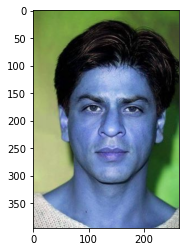

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(395, 264)

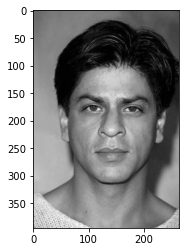

In [5]:
plt.imshow(gray, cmap='gray')

In [6]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 48, 107, 188, 188]])

In [7]:
x,y,w,h = faces[0]
x,y,w,h

(48, 107, 188, 188)

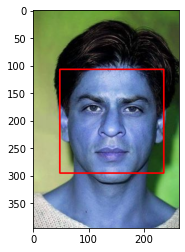

In [8]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

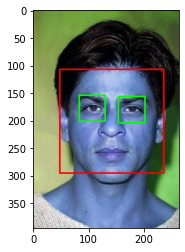

In [9]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

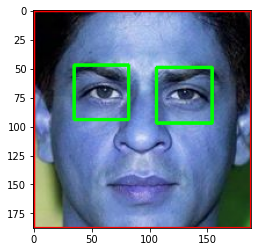

In [10]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

## Defining a function to crop the given proper image 

In [11]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
#     print(img.shape)
    if img is not None:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                return roi_color

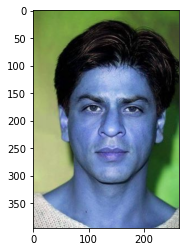

In [12]:
org_img = cv2.imread('./test_images/21.jpg')
plt.imshow(org_img, cmap='gray')

In [13]:
cropped_img = get_cropped_image_if_2_eyes('./test_images/amitabh_testimage.jpg')
if cropped_img is not None:
    plt.imshow(cropped_img, cmap='gray')


## Code to crop all the images and save them

In [14]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [15]:
import os
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)

In [16]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
img_dirs


['./dataset/amitabh_bachchan',
 './dataset/hrithik_roshan',
 './dataset/kangana_ranaut',
 './dataset/kareena_kapoor',
 './dataset/kim_kardashian',
 './dataset/sharukh_khan',
 './dataset/varun_dhawan']

In [17]:
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)


In [18]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1    

amitabh_bachchan
hrithik_roshan
kangana_ranaut
kareena_kapoor
kim_kardashian
sharukh_khan
varun_dhawan


In [19]:
cropped_image_dirs

['./dataset/cropped/amitabh_bachchan',
 './dataset/cropped/hrithik_roshan',
 './dataset/cropped/kangana_ranaut',
 './dataset/cropped/kareena_kapoor',
 './dataset/cropped/kim_kardashian',
 './dataset/cropped/sharukh_khan',
 './dataset/cropped/varun_dhawan']

## Manually delete the face images which are not of that celebrity

# Data Preprocessing

## Wavelet Transformation to extract features from the cropped images

In [20]:
import pywt

In [21]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [22]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list

## Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [23]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'amitabh_bachchan': 0,
 'hrithik_roshan': 1,
 'kangana_ranaut': 2,
 'kareena_kapoor': 3,
 'kim_kardashian': 4,
 'sharukh_khan': 5,
 'varun_dhawan': 6}

In [24]:
X, y = [], []

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name]) 


In [25]:
X

[array([[255],
        [255],
        [255],
        ...,
        [  0],
        [  0],
        [  0]], dtype=uint8),
 array([[255],
        [255],
        [255],
        ...,
        [236],
        [221],
        [ 69]], dtype=uint8),
 array([[120],
        [ 49],
        [ 59],
        ...,
        [  0],
        [  2],
        [  1]], dtype=uint8),
 array([[121],
        [161],
        [156],
        ...,
        [252],
        [247],
        [244]], dtype=uint8),
 array([[163],
        [167],
        [178],
        ...,
        [254],
        [ 11],
        [253]], dtype=uint8),
 array([[152],
        [137],
        [135],
        ...,
        [ 51],
        [ 52],
        [183]], dtype=uint8),
 array([[ 64],
        [ 68],
        [ 76],
        ...,
        [  0],
        [  0],
        [255]], dtype=uint8),
 array([[ 87],
        [104],
        [111],
        ...,
        [208],
        [ 10],
        [ 22]], dtype=uint8),
 array([[ 85],
        [ 74],
        [ 78],
        ...

In [26]:
y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


In [27]:
df = pd.DataFrame(y)

In [28]:
df.value_counts()

4    72
3    69
2    61
6    55
1    53
5    49
0    20
dtype: int64

In [29]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(379, 4096)

In [30]:
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

In [31]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(random_state=42),
        'params' : {
            'randomforestclassifier__n_estimators': [5,10,20],
            'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
            'randomforestclassifier__bootstrap': [True],
            'randomforestclassifier__min_samples_leaf': [1,2,3, 4, 5],
            'randomforestclassifier__min_samples_split': [3, 4, 6, 8, 10, 12]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(multi_class='auto'),
        'params': {
#             'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear'],
            'logisticregression__solver': ['liblinear'],
            'logisticregression__C': [1,5,10]
#             'logisticregression__penalty': [None,'l1','l2','elasticnet']
        }
    },
    'kneighborsclassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'kneighborsclassifier__n_neighbors': list(range(1,30))
#             'kneighborsclassifier__p': [1,2],
#             'kneighborsclassifier__leaf_size': list(range(1,50))
        }
    },
    'adaboostclassifier': {
        'model': AdaBoostClassifier(),
        'params': {
            'adaboostclassifier__n_estimators': [5,10,20]
        }
    },
    'gaussiannb': {
        'model': GaussianNB(),
        'params': {
            'gaussiannb__var_smoothing': np.logspace(0,-9, num=100)
        }
    }

    
}

In [32]:
scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(QuantileTransformer(n_quantiles=320), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X,y)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

,model,best_score,best_params
0,svm,0.733474,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.538561,"{'randomforestclassifier__bootstrap': True, 'r..."
2,logistic_regression,0.744035,"{'logisticregression__C': 1, 'logisticregressi..."
3,kneighborsclassifier,0.498842,{'kneighborsclassifier__n_neighbors': 1}
4,adaboostclassifier,0.290211,{'adaboostclassifier__n_estimators': 20}
5,gaussiannb,0.496211,{'gaussiannb__var_smoothing': 0.03511191734215...


In [33]:
best_estimators

{'svm': Pipeline(steps=[('quantiletransformer', QuantileTransformer(n_quantiles=320)),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('quantiletransformer', QuantileTransformer(n_quantiles=320)),
                 ('randomforestclassifier',
                  RandomForestClassifier(max_features='auto',
                                         min_samples_split=10, n_estimators=20,
                                         random_state=42))]),
 'logistic_regression': Pipeline(steps=[('quantiletransformer', QuantileTransformer(n_quantiles=320)),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))]),
 'kneighborsclassifier': Pipeline(steps=[('quantiletransformer', QuantileTransformer(n_quantiles=320)),
                 ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))]),
 'adaboostclassifier': Pipeline(steps=[('quantiletransformer', Quant

In [34]:
df['best_params'][2]

{'logisticregression__C': 1, 'logisticregression__solver': 'liblinear'}

In [64]:
# #################################################################################3

In [65]:
best_estimators['logistic_regression']

Pipeline(steps=[('quantiletransformer', QuantileTransformer(n_quantiles=320)),
                ('logisticregression',
                 LogisticRegression(C=1, solver='liblinear'))])

## Getting accuracy with extra test_data

In [35]:
from sklearn.pipeline import Pipeline
params2 = {'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear'],
            'logisticregression__C': [1,5,10],
            'logisticregression__penalty': [None,'l1','l2','elasticnet']}
pipe2 = Pipeline([('scaler', QuantileTransformer(n_quantiles=320)), ('logisticregression', LogisticRegression())])
clf2 =  GridSearchCV(pipe2, param_grid=params2, cv=5, return_train_score=False)
clf2.fit(X,y)
df_lg = pd.DataFrame({
    'model': 'logisticregression',
    'best_score': clf2.best_score_,
    'best_params': clf2.best_params_
})
df_lg

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pr

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
C:\Python3105\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (320) is greater than the total number of samples (303). n_quantiles is set to n_samples.
  warnings.w

,model,best_score,best_params
logisticregression__C,logisticregression,0.751965,5
logisticregression__penalty,logisticregression,0.751965,l2
logisticregression__solver,logisticregression,0.751965,newton-cg


In [36]:
best_estimator2 = clf2.best_estimator_

In [37]:
best_estimator2

Pipeline(steps=[('scaler', QuantileTransformer(n_quantiles=320)),
                ('logisticregression',
                 LogisticRegression(C=5, solver='newton-cg'))])

In [38]:
test_dir = './test_images/'
testimages_list = []

for entry in os.scandir(test_dir):
    testimages_list.append(entry.path)

In [39]:
count=1
path_croppedimgs= []
for entry in os.scandir(test_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = test_dir + 'croppedtest_img'
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                
            cropped_file_name = str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            path_croppedimgs.append(cropped_file_path)
            count += 1    

In [40]:
cropped_img2 = []

for image in os.scandir(cropped_folder):
    cropped_img2.append(image.path)
    

In [41]:
from sklearn.metrics import confusion_matrix

X_test_img = []

for training_image in cropped_img2:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X_test_img.append(combined_img)
        
X_test_img = np.array(X_test_img).reshape(len(cropped_img2),4096).astype(float)


In [42]:
X_test_img[0]

array([ 52.,  59., 122., ...,  46.,  50.,  49.])

In [43]:
class_dict

{'amitabh_bachchan': 0,
 'hrithik_roshan': 1,
 'kangana_ranaut': 2,
 'kareena_kapoor': 3,
 'kim_kardashian': 4,
 'sharukh_khan': 5,
 'varun_dhawan': 6}

In [44]:
y_test_img = np.array([2,2,2,2,2,2,5,5,5,5,5,3,3,3,0,3,3,3,3,6,6,6,6,6,6,1,1,1,1,1,1,1,1,1,0,0,2,2,2,2,2,2,2,2,2,6,6])

In [45]:
len(y_test_img)

47

In [46]:
y_test_img

array([2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 3, 3, 3, 0, 3, 3, 3, 3, 6, 6, 6,
       6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 6, 6])

In [47]:
res_extra = best_estimator2.predict(X_test_img)

In [48]:
res_extra

array([2, 5, 5, 5, 3, 3, 4, 5, 3, 3, 3, 2, 3, 6, 4, 1, 6, 1, 6, 1, 1, 2,
       2, 1, 2, 1, 1, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 6, 6, 2,
       2, 5, 2])

In [49]:
best_estimator2.score(X_test_img,y_test_img)

0.2553191489361702

In [63]:
# #############################################################################################################

In [66]:
best_estimators['logistic_regression'].predict(X_test_img)

array([2, 5, 5, 5, 3, 3, 4, 5, 3, 3, 3, 2, 3, 3, 4, 1, 6, 1, 6, 1, 1, 2,
       2, 1, 3, 1, 5, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 6, 6, 2,
       2, 5, 2])

In [67]:
best_estimators['logistic_regression'].score(X_test_img,y_test_img)

0.2553191489361702

## Getting accuracy with train-test split 

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

lnreg = LogisticRegression(C=5, penalty='l2', solver='lbfgs', random_state=42)
pipe_tt = Pipeline([('scaler', StandardScaler()), ('logisticregression', lnreg)])
pipe_tt.fit(X_train, y_train)

C:\Python3105\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=5, random_state=42))])

In [70]:
res_tt = pipe_tt.predict(X_test)

In [53]:
pipe_tt.score(X_test, y_test)

0.6736842105263158

In [54]:
np.array(y_test)

array([3, 5, 5, 4, 4, 2, 6, 1, 3, 1, 5, 6, 4, 3, 5, 1, 5, 3, 1, 6, 6, 3,
       4, 6, 3, 3, 3, 4, 4, 4, 5, 0, 0, 5, 1, 2, 3, 2, 1, 4, 0, 1, 1, 5,
       5, 6, 5, 0, 1, 4, 0, 2, 2, 0, 5, 3, 5, 4, 5, 1, 6, 4, 4, 6, 2, 5,
       4, 1, 1, 6, 3, 5, 4, 4, 5, 1, 0, 3, 5, 4, 6, 3, 4, 1, 5, 4, 2, 6,
       2, 2, 3, 1, 3, 3, 1])

In [55]:
res_tt

array([5, 5, 1, 4, 4, 4, 6, 5, 3, 1, 6, 6, 3, 6, 3, 2, 2, 3, 1, 6, 6, 3,
       4, 6, 6, 3, 3, 4, 4, 3, 3, 5, 0, 5, 6, 2, 2, 2, 1, 4, 0, 6, 1, 6,
       5, 6, 5, 0, 6, 3, 0, 2, 2, 0, 5, 3, 2, 4, 3, 1, 6, 4, 4, 6, 4, 5,
       4, 1, 1, 4, 3, 6, 4, 4, 3, 1, 2, 3, 5, 4, 6, 3, 4, 1, 5, 4, 2, 1,
       5, 3, 3, 1, 3, 4, 1])

In [56]:
res_tt2 = pipe_tt.predict(X_test_img)

In [57]:
pipe_tt.score(X_test_img, y_test_img)

0.23404255319148937

In [59]:
from sklearn import metrics

In [60]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, res_tt, pos_label=2)
metrics.auc(fpr, tpr)

0.38372093023255816

## Save the trained model

In [61]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_estimator2, 'saved_model.pkl') 

['saved_model.pkl']

## Save class dictionary

In [62]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))